In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import email
import os
import re
import nltk
from bs4 import BeautifulSoup
from collections import Counter

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
# load ham and spam files
ham_fnames = [name for name in sorted(os.listdir("Resources/main_ham"))]
spam_fnames = [name for name in sorted(os.listdir("Resources/main_spam"))]

In [3]:
# Creates a function that takes files in fnames variables and returns a parsed email
def parse_email(fname, spam=False):
    directory = "Resources/main_spam" if spam else "Resources/main_ham"
    with open(os.path.join(directory, fname), "rb") as fp:
        return email.parser.BytesParser().parse(fp)
        
ham_emails = [parse_email(name) for name in ham_fnames]
spam_emails = [parse_email(name, spam=True) for name in spam_fnames]

In [4]:
def html_to_text(email) -> str:
    try:
        soup = BeautifulSoup(email.get_payload(), "html.parser")
        plain = soup.text.replace("=\n", "")
        plain = re.sub(r"\s+", " ", plain)
        return plain.strip()
    except:
        return "nothing"

In [5]:
# General purpose function to convert an email to plain text
def email_to_text(email):
    text_content = ""
    for part in email.walk():
        part_content_type = part.get_content_type()
        if part_content_type not in ['text/plain', 'text/html']:
            continue
        if part_content_type == 'text/plain':
            text_content += part.get_payload()
        else:
            text_content += html_to_text(part)
    return text_content

print("Ham email in plain text:\n", email_to_text(ham_emails[3]))
print("Spam email in plain text:\n", email_to_text(spam_emails[3]))

Ham email in plain text:
 > From:  Valdis.Kletnieks@vt.edu
> Date:  Wed, 21 Aug 2002 02:36:56 -0400
>
> --==_Exmh_778588528P
> Content-Type: text/plain; charset=us-ascii
> 
> On Tue, 20 Aug 2002 22:51:52 EDT, Valdis.Kletnieks@vt.edu said:
> 
> > Ever tried to get MH to *not* have a 'pseq' sequence?  I suspect everybod
> y's
> > looking at a big box that has unseen and pseq in it.  Might want to add
> > 'pseq' to the 'hide by default' list....
> 
> Was it intended that if you added a sequence to the 'never show' list that
> it not take effect till you stopped and restarted exmh?  I added 'pseq',
> then hit 'save' for Preferences - didn't take effect till I restarted.

No it wasn't, and at one point it worked fine.  I'll check and see why it 
stopped working.

Chris
-- 
Chris Garrigues                 http://www.DeepEddy.Com/~cwg/
virCIO                          http://www.virCIO.Com
716 Congress, Suite 200
Austin, TX  78701		+1 512 374 0500

  World War III:  The Wrong-Doers Vs. the Evi

In [6]:
# transforms the email to count the word usage in the message
class EmailToWordsCount(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, to_lowercase=True, remove_punc=True, do_stem=True):
        self.strip_headers = strip_headers
        self.to_lowercase = to_lowercase
        self.remove_punc = remove_punc
        self.do_stem = do_stem
        
        # To perform stemming
        self.stemmer = nltk.PorterStemmer()
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_word_counts = []
        for email in X:
            # text of the email
            plain = email_to_text(email)
            if plain is None:
                plain = "nothing"
            
            if self.to_lowercase:
                plain = plain.lower()
            
            if self.remove_punc:
                plain = plain.replace(".", "")
                plain = plain.replace(",", "")
                plain = plain.replace("!", "")
                plain = plain.replace("?", "")
                plain = plain.replace(";", "")
                
            word_counts = Counter(plain.split())
            if self.do_stem:
                # Stem the word, and add their counts
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    root_word = self.stemmer.stem(word)
                    stemmed_word_counts[root_word] += count
                word_counts = stemmed_word_counts
            
            X_word_counts.append(word_counts)
        return np.array(X_word_counts)

In [7]:
#Build a Numpy matrix with the vocabulary of words to consider and their usage counts
class WordCountVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    # train on list of word counts and build vocabulary
    def fit(self, X, y=None):
        total_word_counts = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_word_counts[word] += count
                
        # Build a vocabulary out of total most common
        self.most_common = total_word_counts.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: i for i, (word, count) in enumerate(self.most_common)}
    
        return self
    # Create the vector out of vocabulary
    def transform(self, X, y=None):
        X_new = np.zeros([X.shape[0], self.vocabulary_size + 1], dtype=int)
        
        # The vectors will contain additional column for counts of words
        # not captured in vocabulary
        for row, word_counts in enumerate(X):
            for word, count in word_counts.items():
                col = self.vocabulary_.get(word, self.vocabulary_size)
                X_new[row, col] += count
                
        return X_new

In [8]:
email_to_cvector = Pipeline([
    ("emailToWords", EmailToWordsCount()), 
    ("wordCountVectorizer", WordCountVectorizer())
])

In [9]:
X = np.array(ham_emails + spam_emails, dtype='object')
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

In [10]:
print(type(X))

<class 'numpy.ndarray'>


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=3301)

print("Training set size: ", X_train.shape, y_train.shape)
print("Testing set size: ", X_test.shape, y_test.shape)

Training set size:  (7479,) (7479,)
Testing set size:  (1870,) (1870,)


In [12]:
# prepare the training and testing set 
X_train_prepared = email_to_cvector.fit_transform(X_train)
X_train_prepared

array([[  7,   6,   0, ...,   0,   0,  57],
       [  9,   7,   0, ...,   0,   0,  42],
       [  1,   5,   4, ...,   0,   0,  60],
       ...,
       [ 14,   9,   0, ...,   0,   0, 134],
       [ 33,  20,   0, ...,   1,   0, 125],
       [  0,   3,   0, ...,   0,   0,  17]])

In [13]:
X_test_prepared = email_to_cvector.transform(X_test)
X_test_prepared

array([[  2,   0,   0, ...,   0,   0,  37],
       [ 23,  21,   0, ...,   0,   0, 168],
       [  2,   3,   0, ...,   0,   0,  19],
       ...,
       [ 16,   7,   0, ...,   0,   0,  63],
       [ 31,  41,  33, ...,   0,   0, 164],
       [  0,   4,   0, ...,   0,   0,  22]])

In [39]:
# Create a function to handle model training and evaluation
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    model_prediction = model.predict(X_test)
    report = classification_report(y_test, model_prediction)
    matrix = confusion_matrix(y_test, model_prediction)
    return report, matrix

# Models to evaluate
models = [
    RandomForestClassifier(random_state=3301),
    LogisticRegression(solver="lbfgs", random_state=3301, max_iter=1000),
    DecisionTreeClassifier(random_state=3301)
]


In [28]:
def extract_metrics(classification_report):
    lines = classification_report.split('\n')
    classes = []
    precision = []
    recall = []
    f1_score = []

    for line in lines[2:-3]:  # Skip headers and micro/macro/weighted averages
        t = line.split()
        if len(t) > 4:  # Ensure the line contains the expected metrics
            classes.append(t[0])
            precision.append(float(t[1]))
            recall.append(float(t[2]))
            f1_score.append(float(t[3]))

    return classes, precision, recall, f1_score

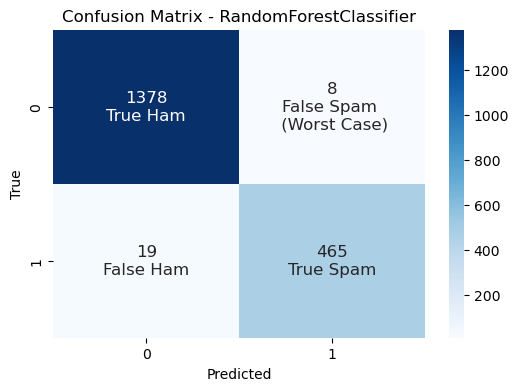

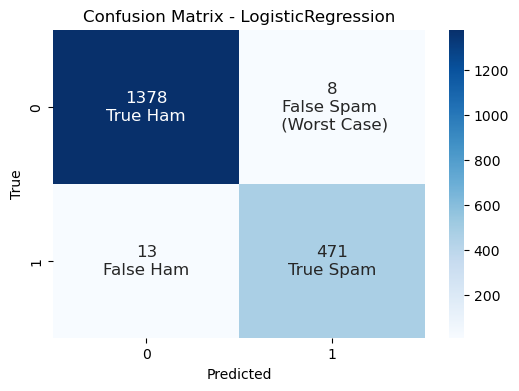

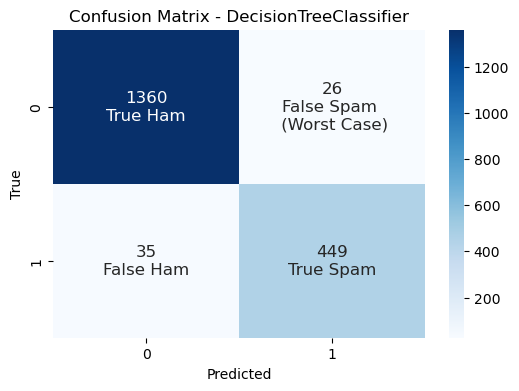

In [40]:
# Lists to store precision, recall, and F1-score values for each class and model
precision_values_class_0 = []
recall_values_class_0 = []
precision_values_class_1 = []
recall_values_class_1 = []
f1_score_values_class_0 = []
f1_score_values_class_1 = []

# Train and evaluate each model
for model in models:
    report, matrix = train_and_evaluate_model(model, X_train_prepared, X_test_prepared, y_train, y_test)
    
    # Extracting metrics from the classification report
    classes, precision, recall, f1_score = extract_metrics(report)
    
    # Storing precision, recall, and F1-score values for class 0 and class 1
    precision_values_class_0.append(precision[0])
    recall_values_class_0.append(recall[0])
    f1_score_values_class_0.append(f1_score[0])
    precision_values_class_1.append(precision[1])
    recall_values_class_1.append(recall[1])
    f1_score_values_class_1.append(f1_score[1])

    # Assuming you have labels for each cell in the confusion matrix
    labels = [['True Ham', 'False Spam \n (Worst Case)'], ['False Ham', 'True Spam']]  # Replace with your actual labels

    # Convert the confusion matrix data to string format with labels
    annotated_data = [[f"{value}\n{label}" for value, label in zip(row, label_row)]
                     for row, label_row in zip(matrix, labels)]

    # Get the model name for title
    model_name = type(model).__name__

    # Visualize confusion matrix with combined labels and data
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, annot=annotated_data, cmap='Blues', fmt='', annot_kws={"size": 12})
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()





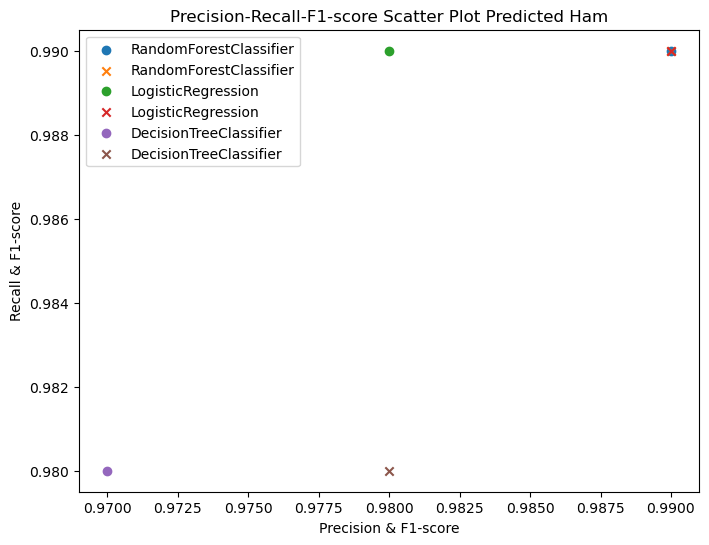

In [20]:
# Scatter plot for Precision-Recall-F1-score of class 0 for each model
plt.figure(figsize=(8, 6))
for i, model in enumerate(models):
    model_name = type(model).__name__
    plt.scatter(precision_values_class_0[i], recall_values_class_0[i], label=model_name, marker='o')
    plt.scatter(f1_score_values_class_0[i], f1_score_values_class_0[i], label=model_name, marker='x')

plt.xlabel('Precision & F1-score')
plt.ylabel('Recall & F1-score')
plt.title('Precision-Recall-F1-score Scatter Plot Predicted Ham')
plt.legend()
plt.show()

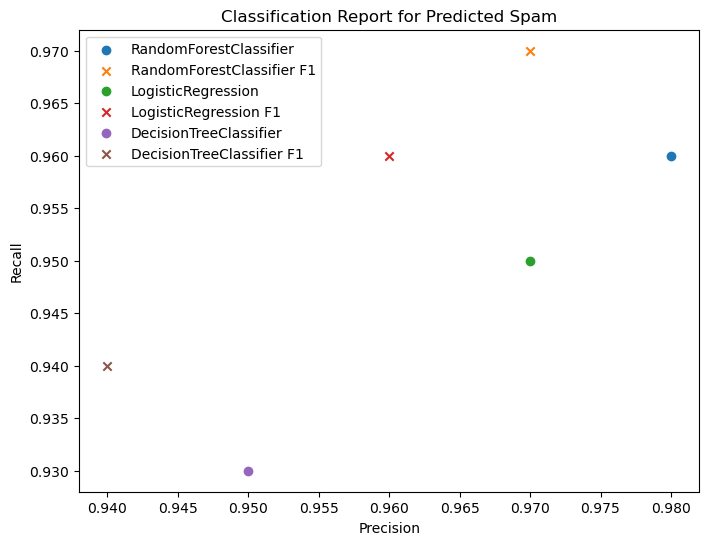

In [19]:
# Scatter plot for Precision-Recall-F1-score of class 1 for each model
plt.figure(figsize=(8, 6))
for i, model in enumerate(models):
    model_name = type(model).__name__
    plt.scatter(precision_values_class_1[i], recall_values_class_1[i], label=model_name, marker='o')
    plt.scatter(f1_score_values_class_1[i], f1_score_values_class_1[i], label=model_name + ' F1', marker='x')

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Classification Report for Predicted Spam')
plt.legend()
plt.show()